In [1]:
import sys
import os
from re import search

from importlib_metadata import distributions
from scipy.stats import gamma

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.insert(0, parent_dir)

import polars as pl
from sklearn.model_selection import train_test_split, cross_val_predict

from classification_pipeline import cat_pipiline

df = pl.read_parquet('../smalldata/classification.parquet')
df_prepared = cat_pipiline(df)
y_lst = ['cat__PlayType', 'cat__offenseFormation', 'cat__passResult', 'cat__passLocationType', 'cat__passTippedAtLine']


# Target selection

In [2]:


def y_select(columns_name):
    """Creates test and train data for the given target column"""
    X_ = df_prepared.drop(columns_name)
    y_ = df_prepared.select(columns_name).to_numpy().ravel()

    X_train, X_test, y_train, y_test = train_test_split(
        X_, y_, test_size=0.2, random_state=42
        # , stratify=y_
    )

    return X_train, X_test, y_train, y_test

In [3]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier

xgb = XGBClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)
svc = SVC(random_state=42, probability=True)
lr = LogisticRegression(random_state=4, max_iter=1000, n_jobs=-1, penalty='elasticnet', solver='saga', l1_ratio=0.3)
knn= KNeighborsClassifier(n_jobs=-1)
ada = AdaBoostClassifier(random_state=5, algorithm='SAMME')


def fast_acc(model, X_train, X_test, y_train, y_test):
    return cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1)



## Cross validation

In [4]:
models_lst = [rf, svc, ada, xgb, lr, knn]


In [5]:
scoring_dict = {}
for col in y_lst:
    scoring_dict[col] = {}
    X_train, X_test, y_train, y_test = y_select(col)
    for model in models_lst:
        v = fast_acc(model, X_train, X_test, y_train, y_test)
        scoring_dict[col][model.__class__.__name__] = v.mean()


/Users/vajk/opt/anaconda3/envs/bdb25/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/vajk/opt/anaconda3/envs/bdb25/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/vajk/opt/anaconda3/envs/bdb25/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/vajk/opt/anaconda3/envs/bdb25/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/vajk/opt/anaconda3/envs/bdb25/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [6]:
scoring_dict


{'cat__PlayType': {'RandomForestClassifier': 0.9966725452269882,
  'SVC': 0.912249252953752,
  'AdaBoostClassifier': 0.9531823571330191,
  'XGBClassifier': 0.9979106658442671,
  'LogisticRegression': 0.9891666616763779,
  'KNeighborsClassifier': 0.8446952230958553},
 'cat__offenseFormation': {'RandomForestClassifier': 0.9449815858339671,
  'SVC': 0.5448425364241187,
  'AdaBoostClassifier': 0.88648319370505,
  'XGBClassifier': 0.9544993442760388,
  'LogisticRegression': 0.7635218664478923,
  'KNeighborsClassifier': 0.5535853129809392},
 'cat__passResult': {'RandomForestClassifier': 0.9901728236851086,
  'SVC': 0.7358196250097311,
  'AdaBoostClassifier': 0.9294292506781803,
  'XGBClassifier': 0.9909464881340911,
  'LogisticRegression': 0.8499577821559245,
  'KNeighborsClassifier': 0.6664084591385164},
 'cat__passLocationType': {'RandomForestClassifier': 0.9571310130486074,
  'SVC': 0.8930588175410652,
  'AdaBoostClassifier': 0.9463751639309903,
  'XGBClassifier': 0.9654883796132726,
  'L

In [7]:
""" scoring_dict= """

' scoring_dict= '

## Trying to get LogisticRegression to converge

In [8]:
from sklearn.model_selection import RandomizedSearchCV
lr=LogisticRegression(random_state=4, max_iter=1000, n_jobs=-1, penalty='elasticnet', solver='saga')
distributions=dict(max_iter=[1000, 2000, 3000, 4000, 5000], l1_ratio=[0.1, 0.2, 0.3, 0.4, 0.5], C=[0.1, 0.2, 0.3, 0.4, 0.5])
clf=RandomizedSearchCV(lr, distributions, random_state=0, n_iter=10, cv=5, n_jobs=-1)
df = pl.read_parquet('../smalldata/classification.parquet')
df_prepared = cat_pipiline(df)
X_train, X_test, y_train, y_test = y_select('cat__passResult')
search=clf.fit(X_train, y_train)
search.best_params_ # {'max_iter': 5000, 'l1_ratio': 0.1, 'C': 0.3}
lr.set_params(**search.best_params_)
lr.fit(X_train, y_train)

cross_val_score(lr, X_train, y_train, cv=5, n_jobs=-1) #still won't converge

/Users/vajk/opt/anaconda3/envs/bdb25/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/vajk/opt/anaconda3/envs/bdb25/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/vajk/opt/anaconda3/envs/bdb25/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/vajk/opt/anaconda3/envs/bdb25/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/vajk/opt/anaconda3/envs/bdb25/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


array([0.90251451, 0.9040619 , 0.90793037, 0.90247678, 0.91408669])

## Correlation matrix

<Axes: >

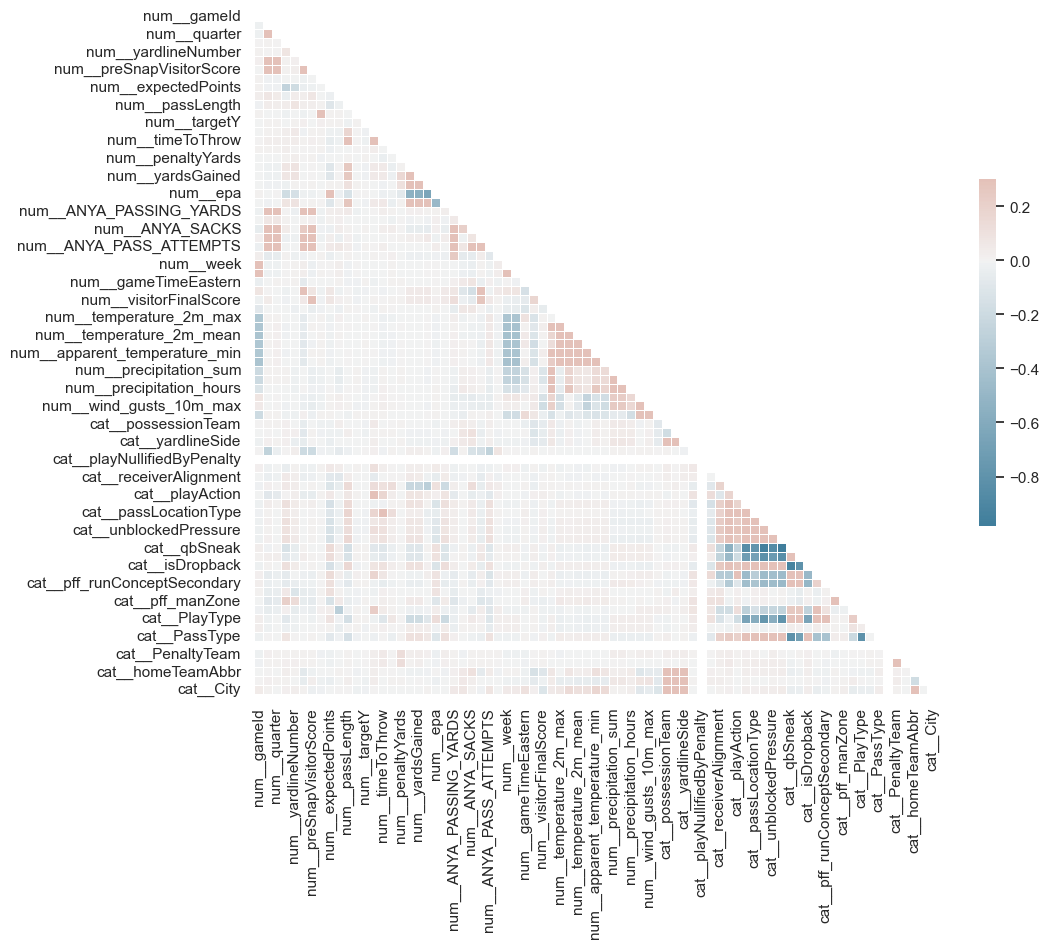

In [9]:

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)
d = df_prepared.to_pandas()

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
            #annot=True
            )

## Feature Correlation

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.target import FeatureCorrelation

def show_feature_correlation(data: pl.DataFrame, features: list):
    for feature in features:
        X = data.drop(feature).to_pandas().reset_index(drop=True)
        y = data.select(feature).to_numpy().ravel()

        visualizer = FeatureCorrelation(
            method='mutual_info-classification',
            sort=True
        )
        visualizer.fit(X, y)
        plt.close()
        feature_scores = list(zip(visualizer.features_, visualizer.scores_))
        feature_scores = [feature_score for feature_score in feature_scores if feature_score[1] > .6]
        x_graph = [feature_score[1] for feature_score in feature_scores]
        y_graph = [feature_score[0] for feature_score in feature_scores]

        plt.figure(figsize=(15, 5))
        ax1 = plt.subplot(121)
        sns.barplot(x=x_graph, y=y_graph, orient="h", ax=ax1)
        plt.title(f'Feature Correlation for {feature}')
        for container in ax1.containers:
            ax1.bar_label(container, label_type='center')

        ax2 = plt.subplot(122)
        clf_score = scoring_dict[feature]
        sns.barplot(x=list(clf_score.values()), y=list(clf_score.keys()), orient="h", ax=ax2)
        plt.title(f'Feature Correlation for {feature}')
        for container in ax2.containers:
            ax2.bar_label(container, label_type='center')

        plt.tight_layout(pad=5)
        plt.show()

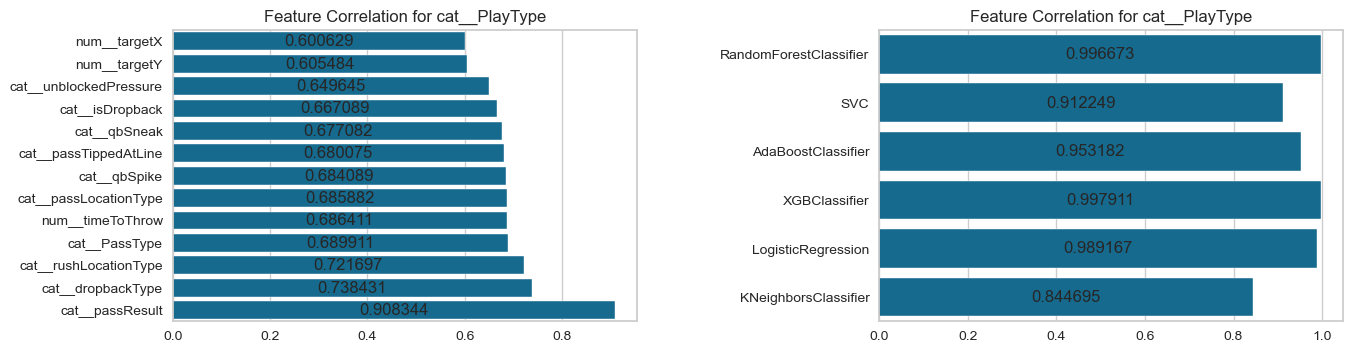

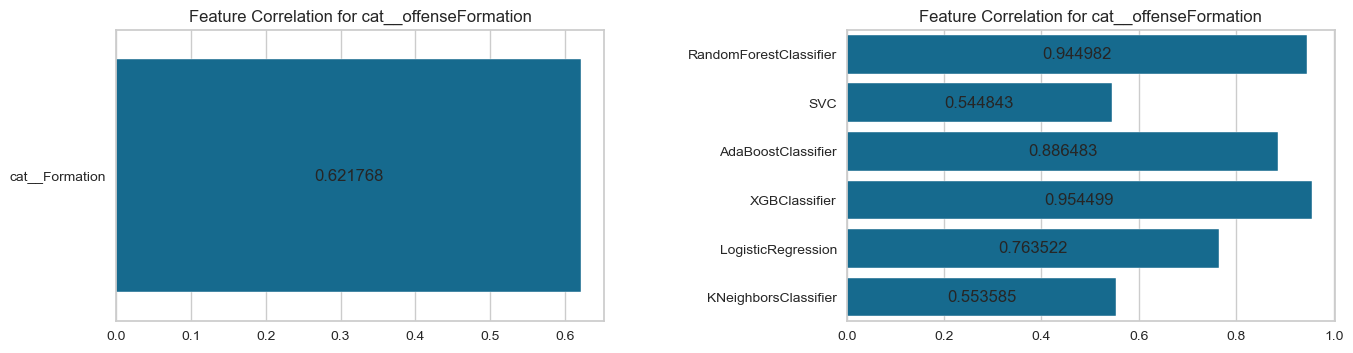

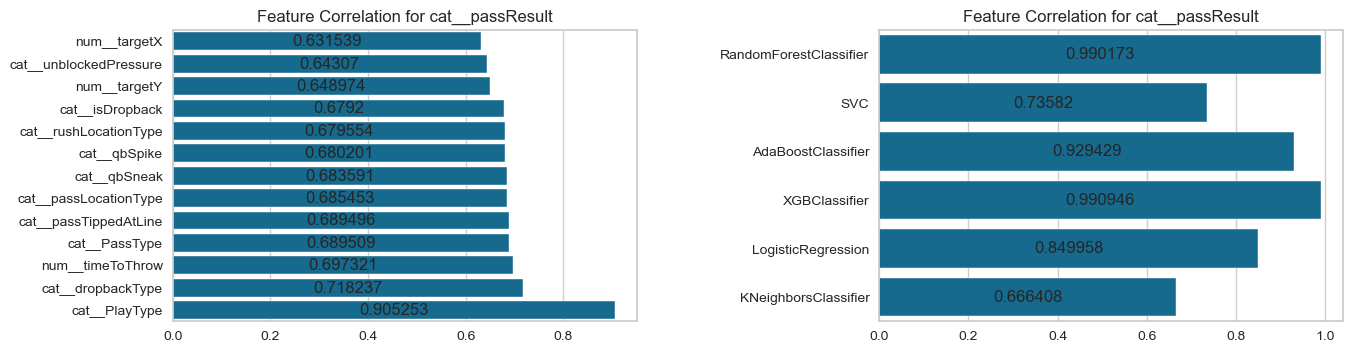

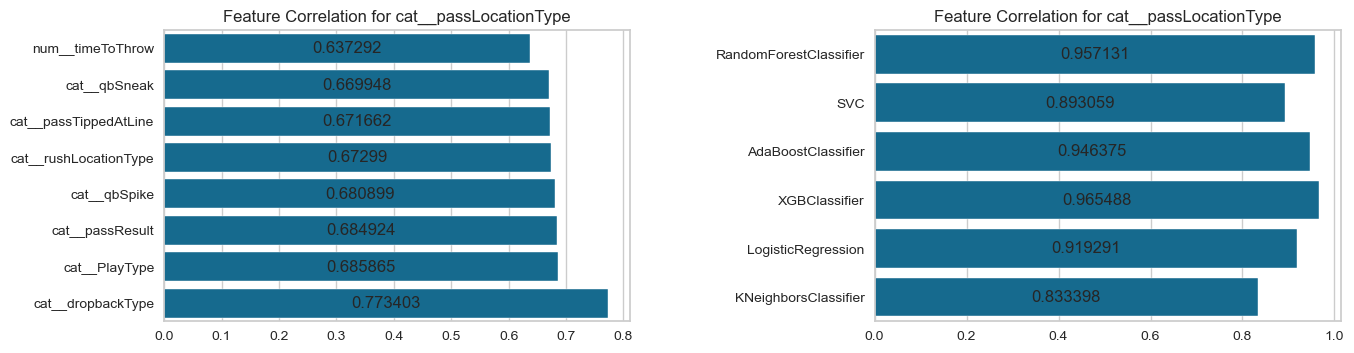

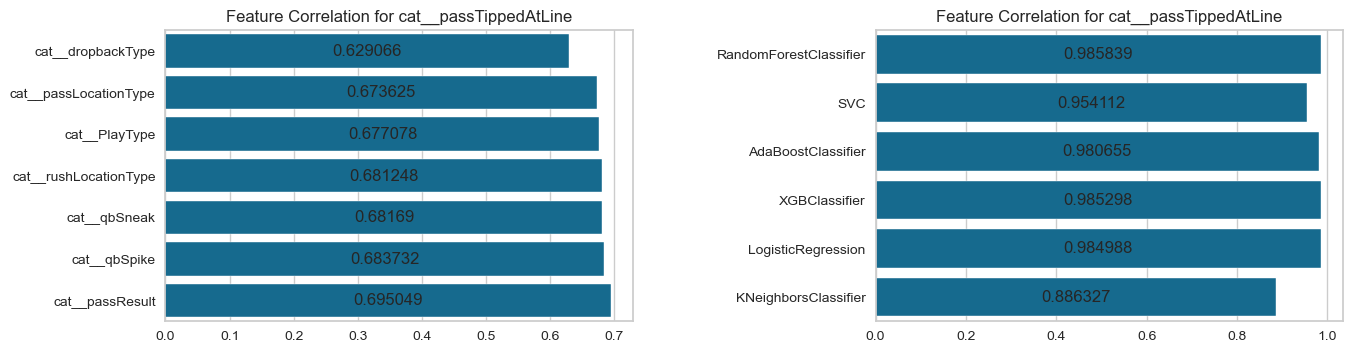

In [11]:
df = pl.read_parquet('/Users/vajk/Desktop/GitHub/Big-data-Ball-2025/smalldata/classification.parquet')
df_prepared = cat_pipiline(df)

show_feature_correlation(df_prepared, y_lst)

Most of the tree based modells are overfitting on the dataset, so we can rule them out. See analysis below for XGB

# Feature selection



## Build a modell for cat__PlayType

In [12]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

df = pl.read_parquet('../smalldata/classification.parquet')
df_prepared = cat_pipiline(df)
X_train, X_test, y_train, y_test = y_select('cat__PlayType')


In [13]:
xgb = XGBClassifier(random_state=42)
cross_val_score(xgb, X_train, y_train, cv=5, n_jobs=-1)

array([0.99845261, 0.99922631, 0.99651838, 0.99767802, 0.99767802])

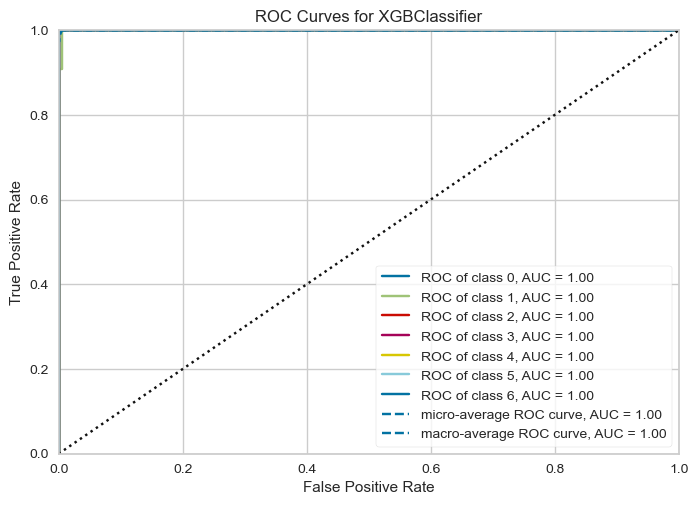

<Axes: title={'center': 'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [14]:
from yellowbrick.classifier import ROCAUC
visualizer=ROCAUC(xgb, per_class=True)
visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

### Prevent XGBClassifier from overfitting

In [15]:
from sklearn.metrics import (
    average_precision_score,
    roc_auc_score,
    RocCurveDisplay,
    balanced_accuracy_score,
)
from sklearn.model_selection import cross_val_predict
from xgboost.callback import EarlyStopping

df = pl.read_parquet("../smalldata/classification.parquet")
df_prepared = cat_pipiline(df)
X_train, X_test, y_train, y_test = y_select("cat__PlayType")
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test)

early_stop = EarlyStopping(
    rounds=1, metric_name="logloss", data_name="validation_0", save_best=False
)
xbg = XGBClassifier(
    random_state=8,
    callbacks=[early_stop],
    verbosity=0,
    booster="dart",
    eta=0.2,
    max_depth=3,
    subsample=0.5,
    reg_lambda=2,
    reg_alpha=5,
    eval_metric="rmse",
    n_estimators=5,
    colsample_bytree=0.3,
)
xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)])

cross_val_score(xgb, X_train, y_train, cv=5, n_jobs=-1)

[0]	validation_0-mlogloss:1.02212
[1]	validation_0-mlogloss:0.69177
[2]	validation_0-mlogloss:0.48910
[3]	validation_0-mlogloss:0.35293
[4]	validation_0-mlogloss:0.25785
[5]	validation_0-mlogloss:0.18990
[6]	validation_0-mlogloss:0.14094
[7]	validation_0-mlogloss:0.10531
[8]	validation_0-mlogloss:0.07915
[9]	validation_0-mlogloss:0.05984
[10]	validation_0-mlogloss:0.04543
[11]	validation_0-mlogloss:0.03487
[12]	validation_0-mlogloss:0.02712
[13]	validation_0-mlogloss:0.02147
[14]	validation_0-mlogloss:0.01733
[15]	validation_0-mlogloss:0.01423
[16]	validation_0-mlogloss:0.01207
[17]	validation_0-mlogloss:0.01047
[18]	validation_0-mlogloss:0.00924
[19]	validation_0-mlogloss:0.00840
[20]	validation_0-mlogloss:0.00774
[21]	validation_0-mlogloss:0.00729
[22]	validation_0-mlogloss:0.00699
[23]	validation_0-mlogloss:0.00677
[24]	validation_0-mlogloss:0.00663
[25]	validation_0-mlogloss:0.00651
[26]	validation_0-mlogloss:0.00645
[27]	validation_0-mlogloss:0.00641
[28]	validation_0-mlogloss:0.0

array([0.99845261, 0.99922631, 0.99651838, 0.99767802, 0.99767802])

In [16]:

y_pred=xgb.predict(X_test)
balanced_accuracy_score(y_test,y_pred )

1.0

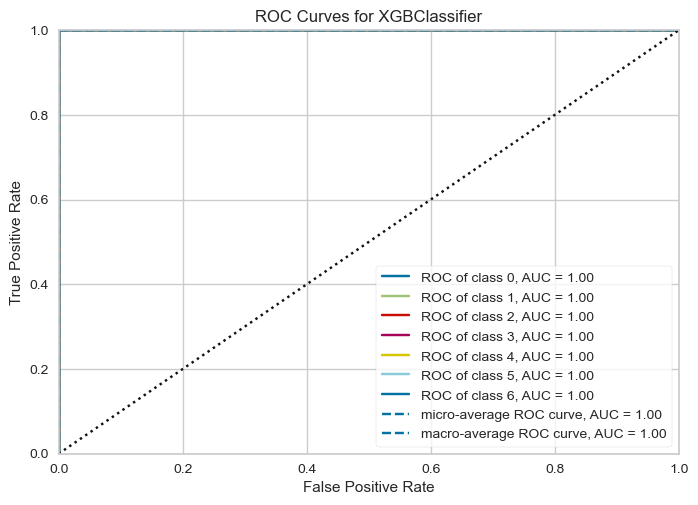

<Axes: title={'center': 'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [17]:
from yellowbrick.classifier import ROCAUC
visualizer=ROCAUC(xgb, per_class=True)
visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()  

[0]	validation_0-mlogloss:1.91185	validation_1-mlogloss:1.91182
[99]	validation_0-mlogloss:0.56515	validation_1-mlogloss:0.56708
Training accuracy: 0.7136
Test accuracy: 0.7143


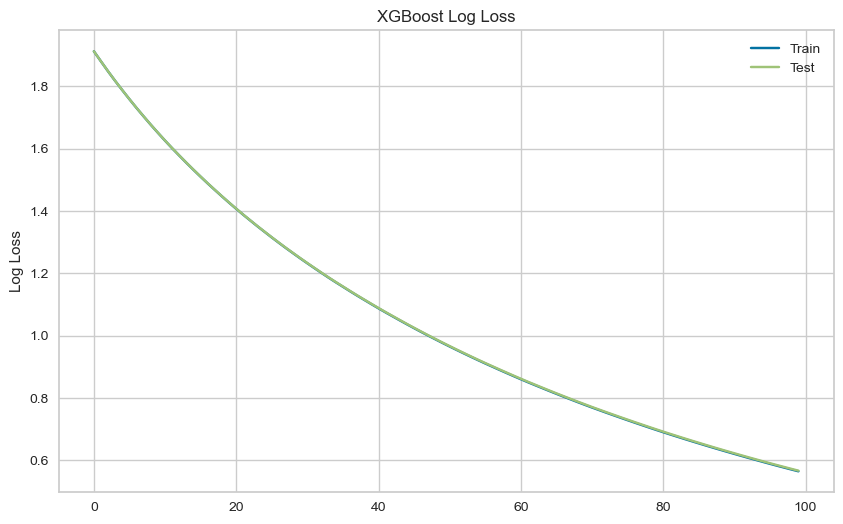

In [18]:
# 1. Set proper hyperparameters to control overfitting
xgb_params = {
    'max_depth': 3,  # Reduce depth to prevent overfitting (default is 6)
    'min_child_weight': 30,  # Increase to be more conservative
    'eta': 0.01,  # Lower learning rate (default 0.3)
    'subsample': 0.8,  # Use 80% of data per tree
    'colsample_bytree': 0.8,  # Use 80% of features per tree
    'gamma': 1,  # Minimum loss reduction for split
    'n_estimators': 100,
    #'early_stopping_rounds': 10  # Stop if no improvement
}

# 2. Create and train model with cross-validation
from sklearn.model_selection import cross_val_score

xgb = XGBClassifier(**xgb_params, eval_metric='mlogloss',)
xgb.fit(X_train, y_train,
    eval_set=[(X_val, y_val), (X_test, y_test)],
       
        verbose=100)

# 3. Check training vs validation scores
train_preds = xgb.predict(X_train)
test_preds = xgb.predict(X_test)

print(f"Training accuracy: {balanced_accuracy_score(y_train, train_preds):.4f}")
print(f"Test accuracy: {balanced_accuracy_score(y_test, test_preds):.4f}")

# 4. Plot learning curves
from xgboost import plot_importance
import matplotlib.pyplot as plt

results = xgb.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

In [19]:
# todo ROC-AUC, gini, confusion-matrix, yellowbrick-cross-validation